In [4]:
from calendar import month_abbr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pathlib import Path
import subprocess
import xarray

In [5]:
def open_var(pp_root, kind, var):
    freq = 'daily' if 'daily' in kind else 'monthly'
    # Naming for the long chunks (have all years combined into one file)
    # Can be changed if the chunk length was changed in the XML
    longslice = '19930101-20191231' if freq == 'daily' else '199301-201912'
    longfile = pp_root / 'pp'/ kind / 'ts' / freq / '27yr' / f'{kind}.{longslice}.{var}.nc'
    if longfile.is_file():
        subprocess.run(f'dmget {longfile.as_posix()}', shell=True, check=True)
        return xarray.open_dataset(longfile)[var]
    # If the single file couldn't be found, check
    # for the shorter file chunks (5 year chunks here)
    elif (pp_root / 'pp'/ kind / 'ts' / freq / '5yr').is_dir():
        files = list((pp_root / 'pp'/ kind / 'ts' / freq / '5yr').glob(f'{kind}.*.{var}.nc'))
        if len(files) == 0:
            raise Exception('Did not find postprocessed files')
        files_str = ' '.join(map(lambda x: x.as_posix(), files))
        subprocess.run(f'dmget {files_str}', shell=True, check=True)
        return xarray.open_mfdataset(files)[var]
    else:
        raise Exception('Did not find postprocessed files')

In [18]:
root = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod')
chlos = open_var(root, 'ocean_cobalt_daily_2d', 'chlos') * 1e6 # kg m-3 -> mg m-3

In [19]:
masks = xarray.open_dataset('/home/Andrew.C.Ross/git/nwa12/data/geography/masks/regions_30m.nc')

In [20]:
masks.data_vars

Data variables:
    areacello  (yh, xh) float32 3MB ...
    geolat     (yh, xh) float32 3MB ...
    geolon     (yh, xh) float32 3MB ...
    MAB        (yh, xh) bool 655kB ...
    GOM        (yh, xh) bool 655kB ...
    SS         (yh, xh) bool 655kB ...
    GB         (yh, xh) bool 655kB ...
    SS_LME     (yh, xh) bool 655kB ...
    NEUS_LME   (yh, xh) bool 655kB ...
    SEUS_LME   (yh, xh) bool 655kB ...
    GOMEX      (yh, xh) bool 655kB ...
    Floridian  (yh, xh) bool 655kB ...
    GSL        (yh, xh) bool 655kB ...
    NGOMEX     (yh, xh) bool 655kB ...
    SGOMEX     (yh, xh) bool 655kB ...
    Antilles   (yh, xh) bool 655kB ...

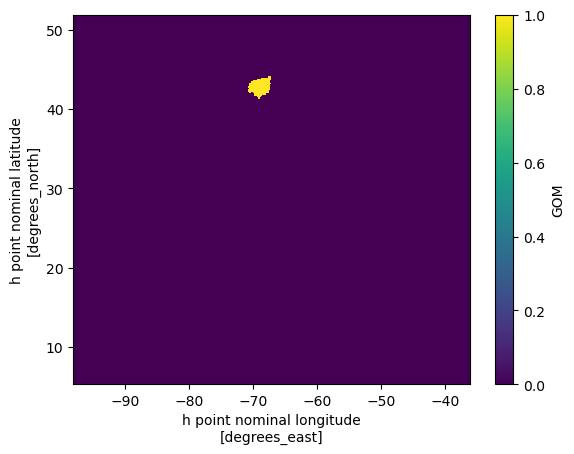

In [21]:
masks['GOM'].plot()

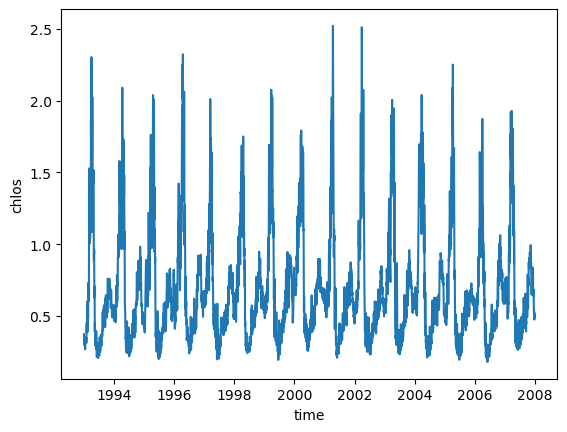

In [22]:
weights = masks['areacello'].where(masks['GOM']).fillna(0)
mean_chlos = chlos.weighted(weights).mean(['yh', 'xh']).compute()
mean_chlos.plot()

In [23]:
def smooth_climatology(da, window=5):
    smooth = da.copy()
    for _ in range(2):
        smooth = xarray.concat([
            smooth.isel(dayofyear=slice(-window, None)),
            smooth,
            smooth.isel(dayofyear=slice(None, window))
        ], 'dayofyear')
        smooth = (
            smooth
            .rolling(dayofyear=(window * 2 + 1), center=True, min_periods=1)
            .mean()
            .isel(dayofyear=slice(window, -window))
        )
    return smooth

# Create climatology by day of year
chlos_climatology = mean_chlos.groupby('time.dayofyear').mean()
# Smooth that day of year climatology
chlos_smooth_climatology = smooth_climatology(chlos_climatology)

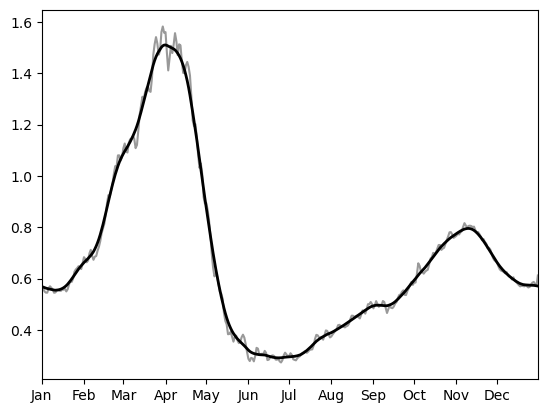

In [24]:
# Make a series of daily dates for the climatology,
# just for plotting purposes
x = pd.date_range('2004-01-01', freq='1D', periods=len(chlos_climatology))
ax = plt.axes()
ax.plot(x, chlos_climatology, c='#999999')
ax.plot(x, chlos_smooth_climatology, c='k', lw=2)
# set x limits to only the period with data
ax.set_xlim(x[0], x[-1])
# label x axis ticks with name of month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

In [25]:
members = []
nens = 5
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    mld = open_var(root, 'ocean_monthly', 'MLD_003')
    members.append(mld)

all_members = xarray.concat(members, dim='member')

In [26]:
 weights = masks['areacello'].where(masks['MAB']).fillna(0)
all_aves = all_members.weighted(weights).mean(['yh', 'xh'])
all_climo = all_aves.groupby('time.month').mean('time').compute()

Text(0.5, 0, '')

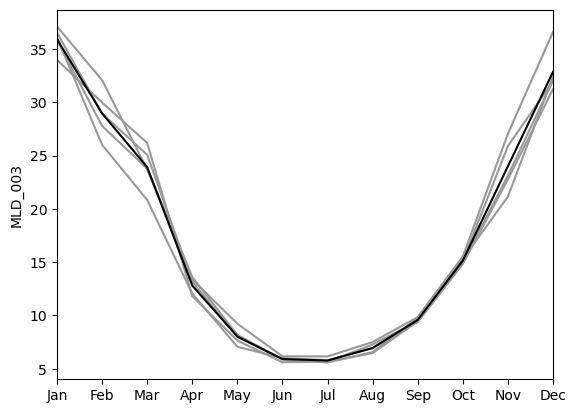

In [27]:
ax = plt.axes()
# Plot each ensemble member to depict uncertainty
all_climo.plot.line(x='month', c='#999999', ax=ax, add_legend=False)
# Plot the ensemble mean
all_climo.mean('member').plot(c='k', ax=ax)
ax.set_xlim(1, 12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_abbr[1:13])
ax.set_xlabel('')

In [28]:
static = xarray.open_dataset('/work/acr/mom6/nwa12/ocean_static.nc')

In [29]:
winter_ens_ave = (
    all_members
    # Select where month is Jan, Feb, or Mar:
    .sel(time=all_members['time.month'].isin([1, 2, 3]))
    # Time and ensemble mean:
    .mean(['time', 'member'])
    .compute()
)

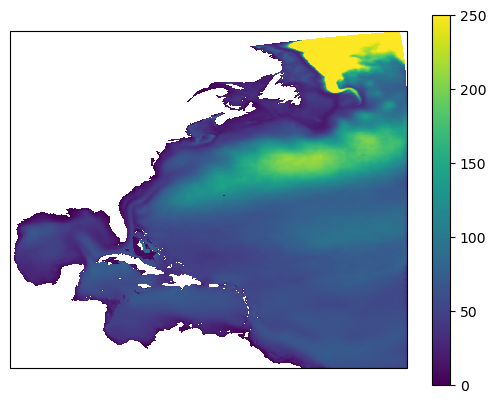

In [30]:
ax = plt.axes(projection=ccrs.PlateCarree())
p = ax.pcolormesh(static.geolon_c, static.geolat_c, winter_ens_ave, vmin=0, vmax=250)
plt.colorbar(p)